In [83]:
#skysurvey/survey/lsst_comcam.py

import pandas as pd
import numpy as np
from shapely.geometry import box
from skysurvey import Survey
from skysurvey.tools.utils import get_skynoise_from_maglimit
from skysurvey.target import SNeIa
from shapely.ops import unary_union
from skysurvey.effects import mw_extinction
import matplotlib.pyplot as plt


def from_dp1_parquet(filepath, zp=30.0, exclude_yband=True, fov_arcmin=40.0):
    """
    Construct a skysurvey.Survey from a DP1 visit-level parquet file.

    Parameters
    ----------
    filepath : str
        Path to a `dp1_visits.parquet` file (or filtered version).
    zp : float
        Zeropoint to use in sky noise conversion (default: 30).
    exclude_yband : bool
        If True, excludes 'y' band visits.
    fov_arcmin : float
        Field of view in arcminutes (default: 40 for LSST ComCam).

    Returns
    -------
    survey : skysurvey.Survey
        Survey object usable with skysurvey.
    """
    df = pd.read_parquet(filepath)

    if exclude_yband:
        df = df[df["band"] != "y"]

    simdata = pd.DataFrame({
        "skynoise": df["limitingMagnitude"].apply(get_skynoise_from_maglimit, zp=zp).values,
        "mjd": df["mjd"].values,
        "band": "lsst" + df["band"].values,
        "gain": 1.0,
        "zp": zp,
        "ra": df["ra"].values,
        "dec": df["dec"].values
    }, index=df.index)

    # Construct square footprint (centered on 0,0 in local projection)
    fov_deg = fov_arcmin / 60.0
    half_size = fov_deg / 2.0
    footprint = box(-half_size, -half_size, half_size, half_size)

    return Survey.from_pointings(simdata, footprint=footprint)

def estimate_snia_population_from_parquet(
    parquet_path,
    zp=30.0,
    exclude_yband=True,
    fov_arcmin=40.0,
    zmin=0.0,
    zmax=0.2,
    include_effects=True,
):
    """
    Load a Survey from DP1 parquet and estimate SNeIa population given z-range and footprint.

    Parameters
    ----------
    parquet_path : str
        Path to visit-level parquet.
    zp : float
        Zeropoint for skynoise conversion.
    exclude_yband : bool
        Whether to exclude 'y' band observations.
    fov_arcmin : float
        Field of view size for footprint box.
    zmin, zmax : float
        Redshift bounds for population simulation.
    include_effects : bool
        Whether to apply mw_extinction.

    Returns
    -------
    snia : SNeIa target object
        The simulated population overlapping the footprint.
    survey : Survey object
        The loaded survey.
    """
    # Load survey from parquet
    survey = from_dp1_parquet(
        parquet_path,
        zp=zp,
        exclude_yband=exclude_yband,
        fov_arcmin=fov_arcmin,
    )

    # Reconstruct shapely.MultiPolygon skyarea from survey visit centers
    visit_df = pd.read_parquet(parquet_path)
    if exclude_yband:
        visit_df = visit_df[visit_df["band"] != "y"]

    fov_deg = fov_arcmin / 60.0
    half_fov = fov_deg / 2.0
    tiles = []
    for _, row in visit_df.iterrows():
        ra = row["ra"]
        dec = row["dec"]
        tile = box(ra - half_fov, dec - half_fov, ra + half_fov, dec + half_fov)
        tiles.append(tile)
    skyarea = unary_union(tiles)

    # Time range of the survey
    tstart, tstop = survey.get_timerange()

    # Build population with or without extinction
    effects = mw_extinction if include_effects else None
    
    snia = SNeIa.from_draw(
        tstart=tstart,
        tstop=tstop,
        skyarea=skyarea,
        zmin=zmin,
        zmax=zmax,
        effect=effects,
    )

    return snia, survey




       skynoise           mjd   band  gain    zp         ra        dec  \
1369  28.491152  60623.257812  lsstr   1.0  30.0  53.327423 -28.072346   
1376  41.121597  60623.257812  lssti   1.0  30.0  53.327236 -28.072054   
1880  41.121597  60623.257812  lssti   1.0  30.0  53.327236 -28.072054   
1881  28.491152  60623.257812  lsstr   1.0  30.0  53.327423 -28.072346   
2987  28.491152  60623.257812  lsstr   1.0  30.0  53.327423 -28.072346   

      fieldid_survey  fieldid  
1369               1   351881  
1376               0   351881  
1880               0   352681  
1881               1   352681  
2987               1   352682  
[60623.2578125 60655.28125  ]


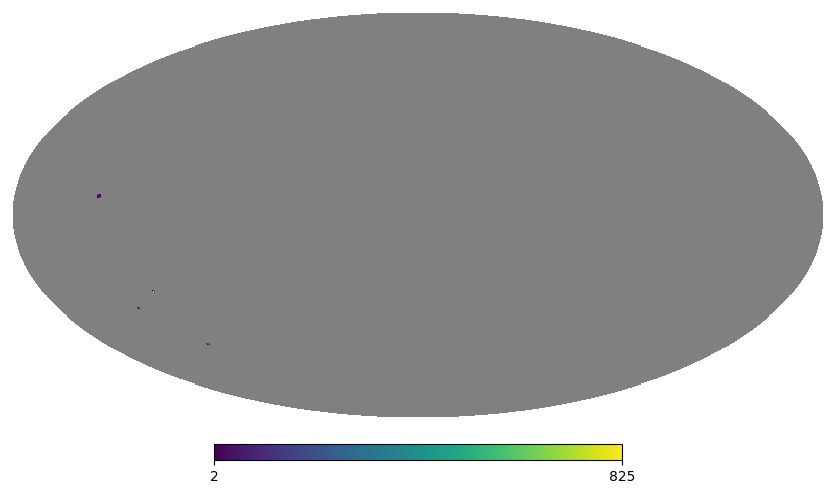

In [85]:
# Load the DP1 visit-level Parquet file

parquet_path = "dp1_visits-ECDFS_EDFS_Fornax_LELF.parquet"  # or your path

# Run and inspect the survey
survey = from_dp1_parquet(parquet_path)

# Show some properties
np.NaN = np.nan  # TEMP FIX for skysurvey compatibility with NumPy 2.0
print(survey)
print(survey.data.head())
print(survey.get_timerange())
survey.show()



In [97]:
zmin=0.1
zmax=1.0

snia, survey = estimate_snia_population_from_parquet(
    parquet_path,
    zmin=zmin,
    zmax=zmax,
)

print(f"Simulated {len(snia.data)} SNeIa between z = {zmin}-{zmax}")
print(snia.data.head())


Simulated 48 SNeIa between z = 0.1-1.0
         z     x1      c            t0         ra        dec     magabs  \
0  0.72535  0.945  0.214  60638.515625  59.674084 -48.525726 -18.751688   
1  0.67225 -1.925 -0.028  60635.941406  40.265717 -34.347076 -19.047930   
2  0.95955  0.170  0.080  60652.488281  40.094090 -34.714264 -19.026575   
3  0.69515 -2.125  0.074  60637.019531  37.624603   6.347019 -18.615725   
4  0.50315 -1.165  0.214  60629.335938  40.128250 -34.634151 -18.342716   

      mwebv     magobs        x0 template  
0  0.010241  24.552237  0.000002    salt2  
1  0.027140  24.054741  0.000004    salt2  
2  0.028728  25.022760  0.000002    salt2  
3  0.065977  24.575537  0.000002    salt2  
4  0.031431  24.000238  0.000004    salt2  


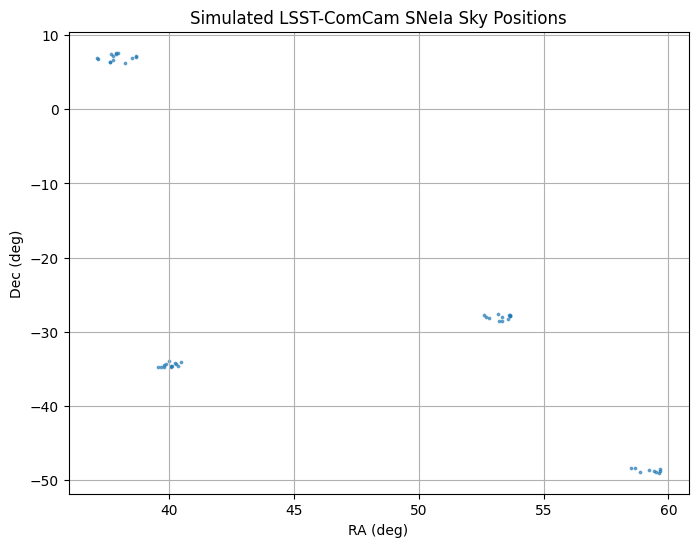

In [99]:

plt.figure(figsize=(8, 6))
plt.scatter(snia.data["ra"], snia.data["dec"], s=3, alpha=0.6)
plt.xlabel("RA (deg)")
plt.ylabel("Dec (deg)")
plt.title("Simulated LSST-ComCam SNeIa Sky Positions")
plt.grid(True)
plt.show()
